In [1]:
conda install rpy2


Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - rpy2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _r-mutex-1.0.1             |      anacondar_1           3 KB  conda-forge
    binutils_impl_linux-64-2.35.1|       h193b22a_2         9.3 MB  conda-forge
    binutils_linux-64-2.35     |      h67ddf6f_30          22 KB  conda-forge
    bwidget-1.9.14             |       ha770c72_0         119 KB  conda-forge
    gcc_impl_linux-64-9.3.0    |      h70c0ae5_19        43.2 MB  conda-forge
    gcc_linux-64-9.3.0         |      hf25ea35_30          23 KB  conda-forge
    gfortran_impl_linux-64-9.3.0|      hc4a2995_19        10.1 MB  conda-forge
    gfortran_linux-64-9.3.0    |      hdc58fab_30          22 KB  conda-forge
    gsl-2.6                    |       he838d99_2         3.2 MB  conda-forge
    gxx_impl_linux-64-9.3.0   

In [2]:
import rpy2.ipython

from rpy2.robjects import pandas2ri   

pandas2ri.activate()

%reload_ext rpy2.ipython

In [3]:
#pip install SNgramExtractor

In [4]:
import shap, time

def ShapleyFiltering(classifier,x_train_vec,vectorizer,k):
    # Create the shap explainers
    t0 = time.time()
    explainer = shap.TreeExplainer(classifier)
    shap_values_train = explainer.shap_values(x_train_vec)
    t1 = time.time()
    timeit=t1-t0
    print('time to compute Shapley values (s):', timeit)

    # From sparse matrix to data frame
    txt_dense_df = pd.DataFrame(x_train_vec.todense(), columns=vectorizer.get_feature_names())
    shap_values_train_df = pd.DataFrame(shap_values_train, columns=txt_dense_df.columns)

    predictions = classifier.predict(x_train_vec.tocsc())
    
    shap_sum = np.abs(shap_values_train_df).mean(axis=0)
    importance_df = pd.DataFrame([txt_dense_df.columns.tolist(), shap_sum.tolist()]).T
    importance_df.columns = ['column_name', 'shap_importance (log-odds)']
    importance_df = importance_df.sort_values('shap_importance (log-odds)', ascending=False)
    importance_df['shap_importance (%)'] = importance_df['shap_importance (log-odds)'].apply(lambda x: 100*x/np.sum(importance_df['shap_importance (log-odds)']))
    
    topN = k
    topk = importance_df.iloc[0:topN]["column_name"]

    print('Cumulative Importance', np.sum(importance_df.iloc[0:topN]["shap_importance (%)"]))
    
    shap_values_imp = shap_values_train_df[topk]
    return shap_values_imp


In [5]:
import pandas as pd
train_en=pd.read_csv('../input/pan2020fake-news-spreaders-task/train_en.csv')
train_es=pd.read_csv('../input/pan2020fake-news-spreaders-task/train_es.csv')

test_en=pd.read_csv('../input/pan2020fake-news-spreaders-task/test_en.csv')
test_es=pd.read_csv('../input/pan2020fake-news-spreaders-task/test_es.csv')

In [6]:
wanted=list("qwertyuioplkjhgfdsazxcvbnmQWERTYUIOPLKJHGFDSAZXCVBNM")
def clean(text):
  text=text.split(' ')
  te=[]
  for w in text:
    w1=''
    for c in w:
      if c in wanted:
        w1+=c
    if len(w1)>2:
      te.append(w1)
    
  return ' '.join(te).strip().lower()

#only for english---skip for spanish
train_en['cleaned']=[clean(x) for x in train_en.tweets]
test_en['cleaned']=[clean(x) for x in test_en.tweets]

train_es['cleaned']=[clean(x) for x in train_es.tweets]
test_es['cleaned']=[clean(x) for x in test_es.tweets]

In [7]:
from sklearn import model_selection, preprocessing, metrics, svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition, ensemble

import pandas as pd
import numpy as np

import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer



In [8]:
'''from SNgramExtractor import SNgramExtractor

def get_sngrams(text):
  
  SNgram_obj=SNgramExtractor(text,meta_tag='original',trigram_flag='yes')#,nlp_model=nlp)# for english nlp_model=None--for spanish nlp model should be set into nlp which in beging we downloaded
  output=SNgram_obj.get_SNgram()

  return output['SNBigram'].split(' ')+output['SNTrigram'].split(' ')'''

"from SNgramExtractor import SNgramExtractor\n\ndef get_sngrams(text):\n  \n  SNgram_obj=SNgramExtractor(text,meta_tag='original',trigram_flag='yes')#,nlp_model=nlp)# for english nlp_model=None--for spanish nlp model should be set into nlp which in beging we downloaded\n  output=SNgram_obj.get_SNgram()\n\n  return output['SNBigram'].split(' ')+output['SNTrigram'].split(' ')"

In [9]:
#get_sngrams(train_en['tweets'][0])

In [75]:
sentences=list(train_en.cleaned)
from scipy.sparse import hstack
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 3),
    max_features=30000)
word_vectorizer.fit(sentences)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 5),
    max_features=30000)
char_vectorizer.fit(sentences)


'''sn_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer=get_sngrams,
    
    max_features=40000)
sn_vectorizer.fit(sentences)'''


train_word_features = word_vectorizer.transform(train_en.cleaned)
test_word_features = word_vectorizer.transform(test_en.cleaned)

train_char_features = char_vectorizer.transform(train_en.cleaned)
test_char_features = char_vectorizer.transform(test_en.cleaned)

'''train_sn_features = sn_vectorizer.transform(train_en.cleaned)
test_sn_features = sn_vectorizer.transform(test_en.cleaned)'''


x_train = hstack([train_char_features, train_word_features])#,train_sn_features])
x_test = hstack([test_char_features, test_word_features])#,test_sn_features])

y_train=train_en.label
y_test=test_en.label

In [76]:
print ('Shape of Sparse Matrix: ', x_train.shape)
print ('Amount of Non-Zero occurences: ', x_train.nnz)
print ('sparsity: %.2f%%' % (100.0 * x_train.nnz /
                             (x_train.shape[0] * x_train.shape[1])))

Shape of Sparse Matrix:  (300, 60000)
Amount of Non-Zero occurences:  2468499
sparsity: 13.71%


In [77]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score


lr=LogisticRegression(C=20)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test) 
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7634    0.7100    0.7358       100
           1     0.7290    0.7800    0.7536       100

    accuracy                         0.7450       200
   macro avg     0.7462    0.7450    0.7447       200
weighted avg     0.7462    0.7450    0.7447       200



In [78]:
svm_clf=SVC(kernel='linear',probability=True)
svm_clf.fit(x_train, y_train)
y_pred = svm_clf.predict(x_test)
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7660    0.7200    0.7423       100
           1     0.7358    0.7800    0.7573       100

    accuracy                         0.7500       200
   macro avg     0.7509    0.7500    0.7498       200
weighted avg     0.7509    0.7500    0.7498       200



In [79]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7283    0.6700    0.6979       100
           1     0.6944    0.7500    0.7212       100

    accuracy                         0.7100       200
   macro avg     0.7114    0.7100    0.7095       200
weighted avg     0.7114    0.7100    0.7095       200



In [80]:
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier



#mnb=MultinomialNB()
mlp=RandomForestClassifier(n_estimators=1000)
xgb_clf=SVC(kernel='linear',probability=True)
lr=LogisticRegression()
estimators=[('lr', lr), ('mlp', mlp),('xgb', xgb_clf)]
clf = VotingClassifier(estimators, voting='soft')
ensemble =clf


ensemble.fit(x_train, y_train)

y_pred = ensemble.predict(x_test) 
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7526    0.7300    0.7411       100
           1     0.7379    0.7600    0.7488       100

    accuracy                         0.7450       200
   macro avg     0.7452    0.7450    0.7449       200
weighted avg     0.7452    0.7450    0.7449       200



In [81]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_label):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return classifier, metrics.accuracy_score(predictions, valid_label), metrics.classification_report(predictions, valid_label,digits=4)

In [82]:
# Extereme Gradient Boosting on Count Vectors
classifier, accuracy, confusion_matrix = train_model(xgboost.XGBClassifier(), train_char_features, y_train, test_char_features, y_test)
print("Xgb, Accuracy: ", accuracy)
print(confusion_matrix)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:53:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, Accuracy:  0.635
              precision    recall  f1-score   support

           0     0.6200    0.6392    0.6294        97
           1     0.6500    0.6311    0.6404       103

    accuracy                         0.6350       200
   macro avg     0.6350    0.6351    0.6349       200
weighted avg     0.6355    0.6350    0.6351       200



In [83]:
vocab=ShapleyFiltering(classifier,train_char_features,char_vectorizer,15000)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


time to compute Shapley values (s): 0.2854878902435303
Cumulative Importance 100.0


In [84]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 5),
    vocabulary= vocab)
char_vectorizer.fit(sentences)

TfidfVectorizer(analyzer='char', ngram_range=(2, 5), strip_accents='unicode',
                sublinear_tf=True,
                vocabulary=          tru      tag         bs      t ba       rai     rl us       bar  \
0    0.890163 -0.016491 -0.471654 -0.130093  0.142820  0.120922 -0.040013   
1    0.882915  0.538169  0.232390 -0.102851  0.197417  0.137908  0.120971   
2    0.617736  0.763886  0.373447 -0.169638  0.174929  0.162985 -0.172969   
3   -0.649243  0.585357  0.294760 -0.141312 -0.224866  0.1...
296 -0.175041  0.059986  0.071891  ...   0.0  0.0    0.0    0.0   0.0   0.0   
297 -0.098283 -0.225431 -0.309183  ...   0.0  0.0    0.0    0.0   0.0   0.0   
298 -0.130871 -0.212710 -0.104905  ...   0.0  0.0    0.0    0.0   0.0   0.0   
299 -0.143807 -0.305772 -0.199977  ...   0.0  0.0    0.0    0.0   0.0   0.0   

     shan  shame  sham  shake  
0     0.0    0.0   0.0    0.0  
1     0.0    0.0   0.0    0.0  
2     0.0    0.0   0.0    0.0  
3     0.0    0.0   0.0    0.0  
4     0.0    

In [85]:
# Extereme Gradient Boosting on Count Vectors
classifier, accuracy, confusion_matrix = train_model(xgboost.XGBClassifier(), train_word_features, y_train, test_word_features, y_test)
print("Xgb, Accuracy: ", accuracy)
print(confusion_matrix)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:55:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, Accuracy:  0.68
              precision    recall  f1-score   support

           0     0.6500    0.6915    0.6701        94
           1     0.7100    0.6698    0.6893       106

    accuracy                         0.6800       200
   macro avg     0.6800    0.6807    0.6797       200
weighted avg     0.6818    0.6800    0.6803       200



In [86]:
vocab=ShapleyFiltering(classifier,train_word_features,word_vectorizer,15000)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


time to compute Shapley values (s): 0.27031898498535156
Cumulative Importance 100.0


In [87]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 3),
    vocabulary= vocab)
word_vectorizer.fit(sentences)

TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode', sublinear_tf=True,
                vocabulary=        trump   hashtag  url user    future      from  user url       out  \
0    1.248691  0.005699  0.375242  0.181637  0.178165  0.244054  0.359007   
1    0.943193  1.011413  0.256479  0.238480  0.301806  0.266080 -0.325854   
2    1.253020  0.927811  0.340464  0.311555  0.322027  0.097903 -0.182189   
3   -0.659346  0.144531  0.370806  0.225099  0.209283  0.248072...
298 -0.435547 -0.410297 -0.093573  ...            0.0    0.0    0.0   0.0   
299  0.300205  0.233041 -0.133541  ...            0.0    0.0    0.0   0.0   

     twenty  two dead  two daughters  two cutest fans  two cutest  twitters  
0       0.0       0.0            0.0              0.0         0.0       0.0  
1       0.0       0.0            0.0              0.0         0.0       0.0  
2       0.0       0.0            0.0              0.0         0.0       0.0  
3       0.0       0.0            0.0              0

In [88]:
'''# Extereme Gradient Boosting on Count Vectors
classifier, accuracy, confusion_matrix = train_model(xgboost.XGBClassifier(), train_sn_features, y_train, test_sn_features, y_test)
print("Xgb, Accuracy: ", accuracy)
print(confusion_matrix)'''

'# Extereme Gradient Boosting on Count Vectors\nclassifier, accuracy, confusion_matrix = train_model(xgboost.XGBClassifier(), train_sn_features, y_train, test_sn_features, y_test)\nprint("Xgb, Accuracy: ", accuracy)\nprint(confusion_matrix)'

In [89]:
'''vocab=ShapleyFiltering(classifier,train_sn_features,sn_vectorizer,30000)'''

'vocab=ShapleyFiltering(classifier,train_sn_features,sn_vectorizer,30000)'

In [90]:
'''sn_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer=get_sngrams,
    
    vocabulary= vocab)
sn_vectorizer.fit(sentences)'''

"sn_vectorizer = TfidfVectorizer(\n    sublinear_tf=True,\n    strip_accents='unicode',\n    analyzer=get_sngrams,\n    \n    vocabulary= vocab)\nsn_vectorizer.fit(sentences)"

In [91]:
train_word_features = word_vectorizer.transform(train_en.cleaned)
test_word_features = word_vectorizer.transform(test_en.cleaned)

train_char_features = char_vectorizer.transform(train_en.cleaned)
test_char_features = char_vectorizer.transform(test_en.cleaned)



'''train_sn_features = sn_vectorizer.transform(train_en.cleaned)
test_sn_features = sn_vectorizer.transform(test_en.cleaned)'''


x_train = hstack([train_char_features, train_word_features])#,train_sn_features])
x_test = hstack([test_char_features, test_word_features])#,test_sn_features])


y_train=train_en.label
y_test=test_en.label

In [92]:
print ('Shape of Sparse Matrix: ', x_train.shape)
print ('Amount of Non-Zero occurences: ', x_train.nnz)
print ('sparsity: %.2f%%' % (100.0 * x_train.nnz /
                             (x_train.shape[0] * x_train.shape[1])))

Shape of Sparse Matrix:  (300, 30000)
Amount of Non-Zero occurences:  1238328
sparsity: 13.76%


In [93]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score


lr=LogisticRegression(C=20)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test) 
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7684    0.7300    0.7487       100
           1     0.7429    0.7800    0.7610       100

    accuracy                         0.7550       200
   macro avg     0.7556    0.7550    0.7548       200
weighted avg     0.7556    0.7550    0.7548       200



In [94]:
svm_clf=SVC(kernel='linear',probability=True)
svm_clf.fit(x_train, y_train)
y_pred = svm_clf.predict(x_test)
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7629    0.7400    0.7513       100
           1     0.7476    0.7700    0.7586       100

    accuracy                         0.7550       200
   macro avg     0.7552    0.7550    0.7549       200
weighted avg     0.7552    0.7550    0.7549       200



In [95]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
model=RandomForestClassifier(n_estimators=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7368    0.7000    0.7179       100
           1     0.7143    0.7500    0.7317       100

    accuracy                         0.7250       200
   macro avg     0.7256    0.7250    0.7248       200
weighted avg     0.7256    0.7250    0.7248       200



In [96]:
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier



#mnb=MultinomialNB()
mlp=RandomForestClassifier(n_estimators=5000)
xgb_clf=SVC(kernel='linear',probability=True)
lr=LogisticRegression()
estimators=[('lr', lr), ('mlp', mlp),('xgb', xgb_clf)]
clf = VotingClassifier(estimators, voting='soft')
ensemble =clf


ensemble.fit(x_train, y_train)

y_pred = ensemble.predict(x_test) 
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7849    0.7300    0.7565       100
           1     0.7477    0.8000    0.7729       100

    accuracy                         0.7650       200
   macro avg     0.7663    0.7650    0.7647       200
weighted avg     0.7663    0.7650    0.7647       200



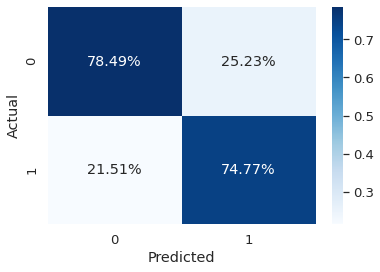

In [97]:
import seaborn as sn
data = {'y_Actual':  y_test ,
        'y_Predicted': y_pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.set(font_scale=1.2)
sn.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,fmt='.2%', cmap='Blues')
plt.show()

**Spanish**

**Without FS**

In [98]:
sentences=list(train_es.cleaned)
from scipy.sparse import hstack
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 3),
    max_features=30000)
word_vectorizer.fit(sentences)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 5),
    max_features=30000)
char_vectorizer.fit(sentences)

'''sn_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer=get_sngrams,
    
    max_features=35000)
sn_vectorizer.fit(sentences)'''



train_word_features = word_vectorizer.transform(train_es.cleaned)
test_word_features = word_vectorizer.transform(test_es.cleaned)

train_char_features = char_vectorizer.transform(train_es.cleaned)
test_char_features = char_vectorizer.transform(test_es.cleaned)


'''
train_sn_features = sn_vectorizer.transform(train_es.cleaned)
test_sn_features = sn_vectorizer.transform(test_es.cleaned)
'''

x_train = hstack([train_char_features, train_word_features])#,train_sn_features])
x_test = hstack([test_char_features, test_word_features])#,test_sn_features])

y_train=train_en.label
y_test=test_en.label

In [99]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score


lr=LogisticRegression(C=20)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test) 
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7500    0.8400    0.7925       100
           1     0.8182    0.7200    0.7660       100

    accuracy                         0.7800       200
   macro avg     0.7841    0.7800    0.7792       200
weighted avg     0.7841    0.7800    0.7792       200



In [100]:
svm_clf=SVC(kernel='linear',probability=True)
svm_clf.fit(x_train, y_train)
y_pred = svm_clf.predict(x_test)
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7658    0.8500    0.8057       100
           1     0.8315    0.7400    0.7831       100

    accuracy                         0.7950       200
   macro avg     0.7986    0.7950    0.7944       200
weighted avg     0.7986    0.7950    0.7944       200



In [101]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
model=RandomForestClassifier(n_estimators=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6991    0.7900    0.7418       100
           1     0.7586    0.6600    0.7059       100

    accuracy                         0.7250       200
   macro avg     0.7289    0.7250    0.7238       200
weighted avg     0.7289    0.7250    0.7238       200



In [102]:
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier



#mnb=MultinomialNB()
mlp=RandomForestClassifier(n_estimators=1000)
xgb_clf=SVC(kernel='linear',probability=True)
lr=LogisticRegression()
estimators=[('lr', lr), ('mlp', mlp),('xgb', xgb_clf)]
clf = VotingClassifier(estimators, voting='soft')
ensemble =clf


ensemble.fit(x_train, y_train)

y_pred = ensemble.predict(x_test) 
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7455    0.8200    0.7810       100
           1     0.8000    0.7200    0.7579       100

    accuracy                         0.7700       200
   macro avg     0.7727    0.7700    0.7694       200
weighted avg     0.7727    0.7700    0.7694       200



In [103]:
print ('Shape of Sparse Matrix: ', x_train.shape)
print ('Amount of Non-Zero occurences: ', x_train.nnz)
print ('sparsity: %.2f%%' % (100.0 * x_train.nnz /
                             (x_train.shape[0] * x_train.shape[1])))

Shape of Sparse Matrix:  (300, 60000)
Amount of Non-Zero occurences:  2727688
sparsity: 15.15%


In [104]:
# Extereme Gradient Boosting on Count Vectors
classifier, accuracy, confusion_matrix = train_model(xgboost.XGBClassifier(), train_char_features, y_train, test_char_features, y_test)
print("Xgb, Accuracy: ", accuracy)
print(confusion_matrix)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:08:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, Accuracy:  0.7
              precision    recall  f1-score   support

           0     0.7800    0.6724    0.7222       116
           1     0.6200    0.7381    0.6739        84

    accuracy                         0.7000       200
   macro avg     0.7000    0.7053    0.6981       200
weighted avg     0.7128    0.7000    0.7019       200



In [105]:
vocab=ShapleyFiltering(classifier,train_char_features,char_vectorizer,15000)
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 5),
    vocabulary= vocab)
char_vectorizer.fit(sentences)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


time to compute Shapley values (s): 0.2869296073913574
Cumulative Importance 100.0


TfidfVectorizer(analyzer='char', ngram_range=(2, 5), strip_accents='unicode',
                sublinear_tf=True,
                vocabulary=          g u      a ur      unda     sobre       mon        fe       can  \
0   -0.311235 -0.118286  0.211431  0.295244  1.028950  0.223845 -0.063482   
1    1.363978  0.512932 -0.189596  0.223214 -0.087594 -0.174142 -0.065421   
2    1.329233  0.260950  0.166257  0.175772 -0.096453  0.175560 -0.065421   
3    1.296465  0.599391  0.211144  0.253964 -0.095713 -0...
297 -0.166102 -0.230500  0.177686  ...    0.0    0.0    0.0    0.0    0.0   
298 -0.169857 -0.164660 -0.158352  ...    0.0    0.0    0.0    0.0    0.0   
299 -0.161877  0.132457  0.161954  ...    0.0    0.0    0.0    0.0    0.0   

     s in  s imp  s img  s ima  s im  
0     0.0    0.0    0.0    0.0   0.0  
1     0.0    0.0    0.0    0.0   0.0  
2     0.0    0.0    0.0    0.0   0.0  
3     0.0    0.0    0.0    0.0   0.0  
4     0.0    0.0    0.0    0.0   0.0  
..    ...    ...    ...   

In [106]:
# Extereme Gradient Boosting on Count Vectors
classifier, accuracy, confusion_matrix = train_model(xgboost.XGBClassifier(), train_word_features, y_train, test_word_features, y_test)
print("Xgb, Accuracy: ", accuracy)
print(confusion_matrix)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:09:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, Accuracy:  0.7
              precision    recall  f1-score   support

           0     0.7800    0.6724    0.7222       116
           1     0.6200    0.7381    0.6739        84

    accuracy                         0.7000       200
   macro avg     0.7000    0.7053    0.6981       200
weighted avg     0.7128    0.7000    0.7019       200



In [107]:
vocab=ShapleyFiltering(classifier,train_word_features,word_vectorizer,15000)
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 3),
    vocabulary= vocab)
word_vectorizer.fit(sentences)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


time to compute Shapley values (s): 0.2786281108856201
Cumulative Importance 100.00000000000001


TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode', sublinear_tf=True,
                vocabulary=     user user user     sobre  hashtag hashtag       pas   hashtag      pero  \
0         -0.849146  0.759617         0.106359  0.435265 -0.043653  0.069140   
1          0.588899  0.817629         0.435242 -0.187115  0.256093  0.238609   
2          0.762236  0.693392         0.408514 -0.257751  0.500464  0.251937   
3          0.781890  0.466546         0.311063  0.334624  0.459006  0.146774   
4          0.578462  0.624454...
0               0.0        0.0     0.0            0.0       0.0        0.0   
1               0.0        0.0     0.0            0.0       0.0        0.0   
2               0.0        0.0     0.0            0.0       0.0        0.0   
3               0.0        0.0     0.0            0.0       0.0        0.0   
4               0.0        0.0     0.0            0.0       0.0        0.0   
..              ...        ...     ...            ...       ...       

In [ ]:
'''# Extereme Gradient Boosting on Count Vectors
classifier, accuracy, confusion_matrix = train_model(xgboost.XGBClassifier(colsample_bytree=0.8, colsample_bylevel=0.8, colsample_bynode=0.8), train_sn_features, y_train, test_sn_features, y_test)
print("Xgb, Accuracy: ", accuracy)
print(confusion_matrix)'''

In [ ]:
'''vocab=ShapleyFiltering(classifier,train_sn_features,sn_vectorizer,30000)'''

In [ ]:
'''sn_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer=get_sngrams,
    
    vocabulary= vocab)
sn_vectorizer.fit(sentences)'''

In [108]:
train_word_features = word_vectorizer.transform(train_es.tweets)
test_word_features = word_vectorizer.transform(test_es.tweets)

train_char_features = char_vectorizer.transform(train_es.tweets)
test_char_features = char_vectorizer.transform(test_es.tweets)


'''
train_sn_features = sn_vectorizer.transform(train_en.cleaned)
test_sn_features = sn_vectorizer.transform(test_en.cleaned)'''


x_train = hstack([train_char_features, train_word_features])#,train_sn_features])
x_test = hstack([test_char_features, test_word_features])#,test_sn_features])


y_train=train_en.label
y_test=test_en.label

In [109]:
print ('Shape of Sparse Matrix: ', x_train.shape)
print ('Amount of Non-Zero occurences: ', x_train.nnz)
print ('sparsity: %.2f%%' % (100.0 * x_train.nnz /
                             (x_train.shape[0] * x_train.shape[1])))

Shape of Sparse Matrix:  (300, 30000)
Amount of Non-Zero occurences:  1219117
sparsity: 13.55%


In [110]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score


lr=LogisticRegression(C=20)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test) 
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7589    0.8500    0.8019       100
           1     0.8295    0.7300    0.7766       100

    accuracy                         0.7900       200
   macro avg     0.7942    0.7900    0.7892       200
weighted avg     0.7942    0.7900    0.7892       200



In [111]:
svm_clf=SVC(kernel='linear',probability=True)
svm_clf.fit(x_train, y_train)
y_pred = svm_clf.predict(x_test)
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7658    0.8500    0.8057       100
           1     0.8315    0.7400    0.7831       100

    accuracy                         0.7950       200
   macro avg     0.7986    0.7950    0.7944       200
weighted avg     0.7986    0.7950    0.7944       200



In [112]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
model=RandomForestClassifier(n_estimators=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6897    0.8000    0.7407       100
           1     0.7619    0.6400    0.6957       100

    accuracy                         0.7200       200
   macro avg     0.7258    0.7200    0.7182       200
weighted avg     0.7258    0.7200    0.7182       200



In [118]:
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier



#mnb=MultinomialNB()
mlp=RandomForestClassifier(n_estimators=5000)
xgb_clf=SVC(kernel='linear',probability=True)
lr=LogisticRegression(C=20)
estimators=[('lr', lr), ('mlp', mlp),('xgb', xgb_clf)]
clf = VotingClassifier(estimators, voting='soft')
ensemble =clf


ensemble.fit(x_train, y_train)

y_pred = ensemble.predict(x_test) 
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7685    0.8300    0.7981       100
           1     0.8152    0.7500    0.7813       100

    accuracy                         0.7900       200
   macro avg     0.7919    0.7900    0.7897       200
weighted avg     0.7919    0.7900    0.7897       200



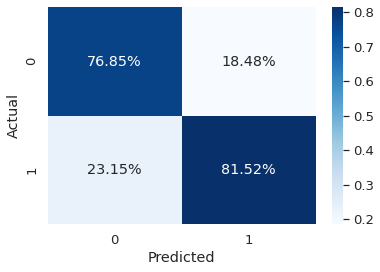

In [119]:
import seaborn as sn
data = {'y_Actual':  y_test ,
        'y_Predicted': y_pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.set(font_scale=1.2)
sn.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,fmt='.2%', cmap='Blues')
plt.show()

In [115]:

model=xgboost.XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred,digits=4))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:12:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0     0.6694    0.8100    0.7330       100
           1     0.7595    0.6000    0.6704       100

    accuracy                         0.7050       200
   macro avg     0.7145    0.7050    0.7017       200
weighted avg     0.7145    0.7050    0.7017       200

